# Case Study 2 : Data Science in Yelp Data

**Required Readings:** 
* [Yelp Dataset Challenge](https://www.yelp.com/dataset_challenge) 
* Please download the Yelp dataset from the above webpage.
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.


** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

Here is an example of the data format. More details are included [here](https://www.yelp.com/dataset_challenge)

## Business Objects

Business objects contain basic information about local businesses. The fields are as follows:

```json
{
  'type': 'business',
  'business_id': (a unique identifier for this business),
  'name': (the full business name),
  'neighborhoods': (a list of neighborhood names, might be empty),
  'full_address': (localized address),
  'city': (city),
  'state': (state),
  'latitude': (latitude),
  'longitude': (longitude),
  'stars': (star rating, rounded to half-stars),
  'review_count': (review count),
  'photo_url': (photo url),
  'categories': [(localized category names)]
  'open': (is the business still open for business?),
  'schools': (nearby universities),
  'url': (yelp url)
}
```
## Checkin Objects
```json
{
    'type': 'checkin',
    'business_id': (encrypted business id),
    'checkin_info': {
        '0-0': (number of checkins from 00:00 to 01:00 on all Sundays),
        '1-0': (number of checkins from 01:00 to 02:00 on all Sundays),
        ...
        '14-4': (number of checkins from 14:00 to 15:00 on all Thursdays),
        ...
        '23-6': (number of checkins from 23:00 to 00:00 on all Saturdays)
    }, # if there was no checkin for a hour-day block it will not be in the dict
}
```

# Problem: pick a data science problem that you plan to solve using Yelp Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using yelp data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

# Data Collection/Processing: 

In [2]:
#
# Enum definition and code to load yelp dataset from multiple files
#
from enum import Enum
import json
import os

# The types of Yelp Data that can be loaded
#
class YelpDataType(Enum):
    BUSINESS = 'business'  #UniqueID attribute: 'business_id'
    USER = 'user'#UniqueID: user_id
    CHECKIN = 'checkin' #Biz Hrs join to Business by attribute: 'business_id' format <day>-<openHr>:<closeHr>
    REVIEW = 'review' #UniqueID: review_id  join to Business by attribute 'business_id', user by attribute 'user_id
    TIP = 'tip' # tip on place, join to Business by attribute 'business_id', user by attribute 'user_id
    def __str__(self):
        return str(self.value)

#
# NOTE: we 'cut' the yelp datasets into files no more than 240 MB
#       this was for easy transfer and box storage
#
# load yelp data that was split in chunks
# ./yelp_<datatype>_<counter>.json
#
def loadYelpData(datatype):
    result = []
    filecount = 1
    while True:
        filename = './yelp_{0}_{1}.json'.format(datatype,filecount)
        if not os.path.isfile(filename):
            return result
        print('  Loading {0}'.format(filename))
        with open(filename, 'r') as f:
            result += json.load(f)
        f.closed
        filecount += 1
    return result



In [2]:
YELP_DATA = {}
for datatype in YelpDataType:
    print('Loading Yelp {0} data'.format(datatype))
    YELP_DATA[datatype] = loadYelpData (datatype)


Loading Yelp business data
  Loading ./yelp_business_1.json
Loading Yelp user data
  Loading ./yelp_user_1.json
  Loading ./yelp_user_2.json
  Loading ./yelp_user_3.json
  Loading ./yelp_user_4.json
  Loading ./yelp_user_5.json
  Loading ./yelp_user_6.json
Loading Yelp checkin data
  Loading ./yelp_checkin_1.json
Loading Yelp review data
  Loading ./yelp_review_1.json
  Loading ./yelp_review_2.json
  Loading ./yelp_review_3.json
  Loading ./yelp_review_4.json
  Loading ./yelp_review_5.json
  Loading ./yelp_review_6.json
  Loading ./yelp_review_7.json
  Loading ./yelp_review_8.json
  Loading ./yelp_review_9.json
  Loading ./yelp_review_10.json
  Loading ./yelp_review_11.json
  Loading ./yelp_review_12.json
  Loading ./yelp_review_13.json
  Loading ./yelp_review_14.json
  Loading ./yelp_review_15.json
  Loading ./yelp_review_16.json
Loading Yelp tip data
  Loading ./yelp_tip_1.json


# Data Exploration: Exploring the Yelp Dataset

**(1) Finding the most popular business categories:** 
* print the top 10 most popular business categories in the dataset and their counts (i.e., how many business objects in each category). Here we say a category is "popular" if there are many business objects in this category (such as 'restaurants').

In [5]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
from collections import Counter
#
# load categories for each business.
# presumes a business only has a category once (not twice)
# returns counter of category array
def loadCategoryCounter(yelpBusinesses):
    categoryArray = []
    for business in yelpBusinesses:
        categories = business['categories']
        if categories:
            for category in business['categories']:
                categoryArray.append(category.lower())
    return Counter(categoryArray)

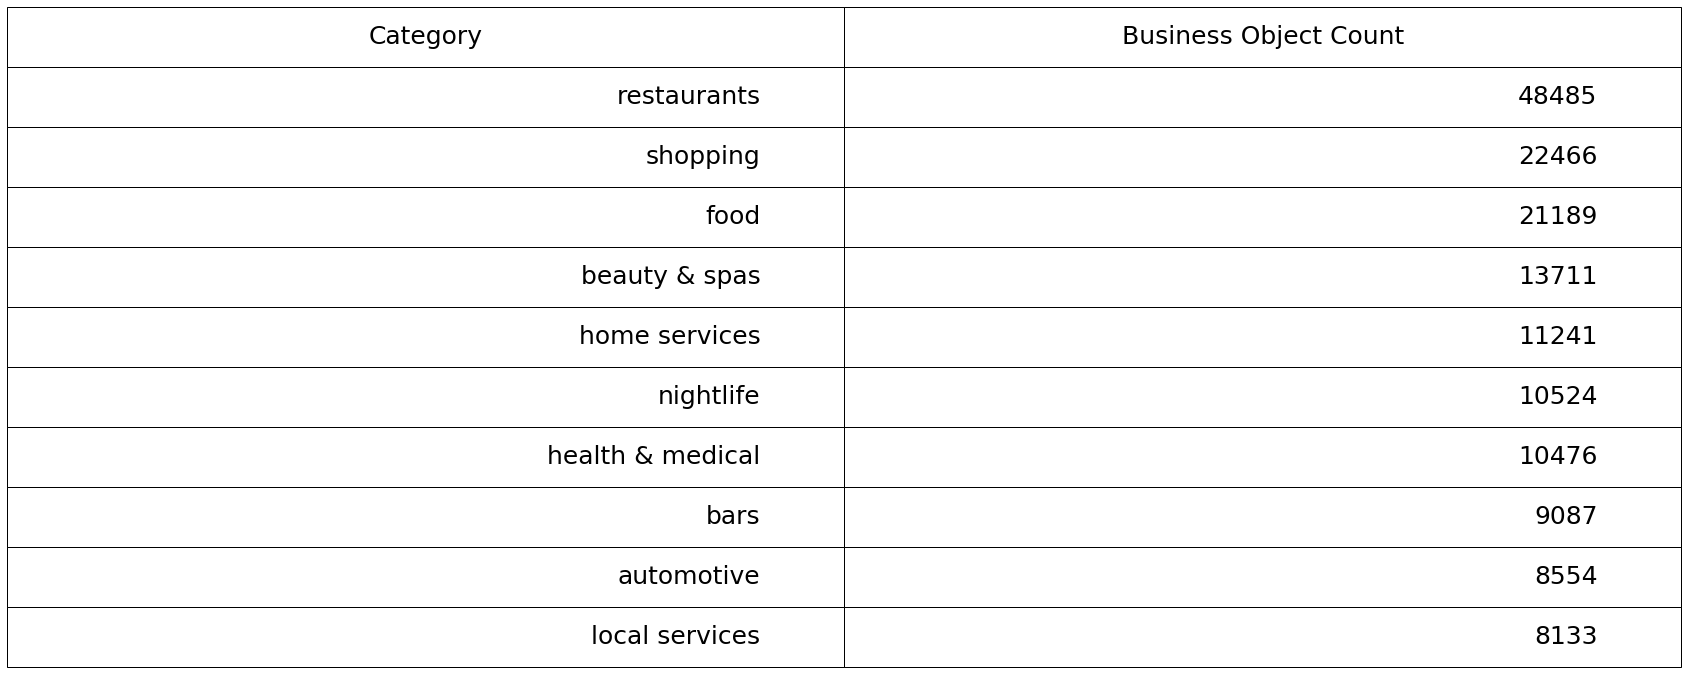

In [23]:
import matplotlib.pyplot as plt
Top10Categories = loadCategoryCounter(YELP_DATA[YelpDataType.BUSINESS]).most_common(10)

fig, ax = plt.subplots(1,1)
ax.axis('tight')
ax.axis('off')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
theTable = ax.table(cellText=Top10Categories,colLabels=('Category','Business Object Count'), loc='center')
theTable.set_fontsize(25)
theTable.scale(5, 5)
plt.show()

** (2) Find the most popular business objects** 
* print the top 10 most popular business objects in the dataset and their counts (i.e., how many checkins in total for each business object).  Here we say a business object is "popular" if the business object attracts a large number of checkins from the users.

In [11]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
from collections import Counter
#
# load businessId as many times as checkin counts exist
# return counter of business ids to rank
def businessIDCheckinCounter(yelpCheckins):
    result = []
    for checkin in yelpCheckins:
        checkinCount = 0
        for checkinTimeCount in checkin['time']:
            checkinCount += int(checkinTimeCount.split(':')[1])
        result += [checkin['business_id']] * checkinCount
    return Counter(result)

#
# convert the array of businesses into
# a business_id -> business map
#
def createBusinessIdMap(yelpBusinesses):
    result = {}
    for business in yelpBusinesses:
        result[business['business_id']] = business
    return result

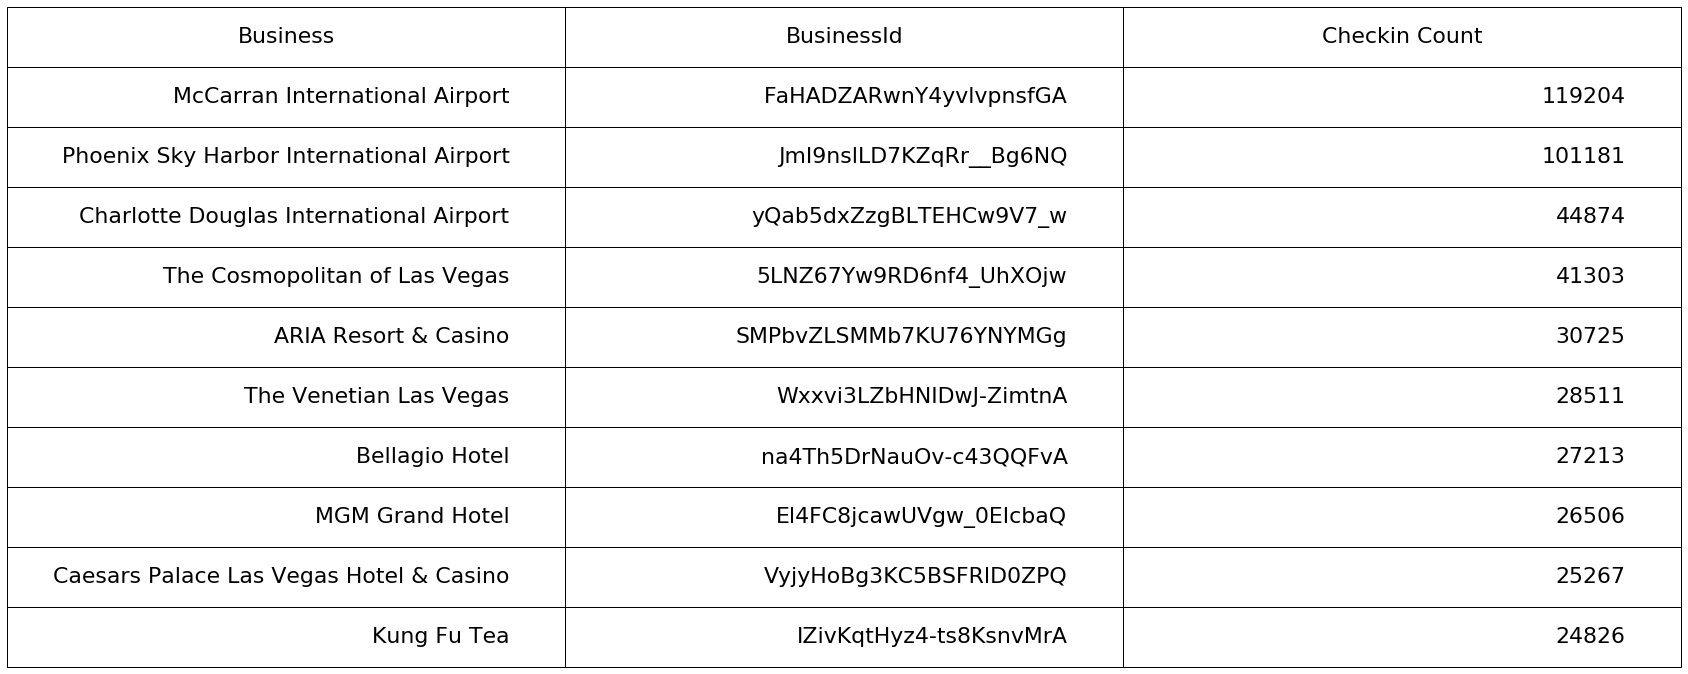

In [22]:
import matplotlib.pyplot as plt
Top10Businesses = businessIDCheckinCounter(YELP_DATA[YelpDataType.CHECKIN]).most_common(10)
businessIdMap = createBusinessIdMap(YELP_DATA[YelpDataType.BUSINESS])

fig, ax = plt.subplots(1,1)
ax.axis('tight')
ax.axis('off')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
theTable = ax.table(cellText=[(businessIdMap[row[0]]['name'], row[0], row[1]) for row in Top10Businesses],
         colLabels=('Business','BusinessId', 'Checkin Count'), loc='center')
theTable.set_fontsize(25)
theTable.scale(5, 5)
plt.show()

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

In [3]:
# 1) combine the reviews and businesses to construct user profiles.
# Aggregating Review and Business data into user profiles
# for collaborative filtering to find 
# suggested new 'friends' and suggested new 'businesses' 
#
import json
import os
import sys
# attribute fields for JSON
USER_ID = 'user_id'
BUSINESS_ID = 'business_id'
POSTAL_CODE = 'postal_code'
CATEGORIES = 'categories'
POSTAL_CODE_MAP = 'postal_code_map'
BUSINESS_MAP = 'business_map'
CATEGORY_MAP = 'category_map'
STARS = 'stars'
REVIEWS = 'reviews'

#
# NOTE: we 'cut' the yelp datasets into files no more than 240 MB
#       this was for easy transfer and box storage
#
# load yelp data that was split in chunks
# ./yelp_<datatype>_<counter>.json
#
def loadYelpData(datatype):
    result = []
    filecount = 1
    while True:
        filename = './yelp_{0}_{1}.json'.format(datatype,filecount)
        if not os.path.isfile(filename):
            return result
        print('  Loading {0}'.format(filename))
        with open(filename, 'r') as f:
            result += json.load(f)
        f.closed
        filecount += 1
    return result

# index passed data by passed keyfield
def indexData(data, keyField):
    result = {}
    for item in data:
        result[item[keyField].lower()] = item
    return result

#
# write  data out into multiple files named like datatype of max size
#
def WriteOutInChunks(data, datatype, maxbytesperfile):
    result = []
    filebytes = 0
    filecount = 1
    filename = './yelp_{0}_{1}.json'.format(datatype, filecount)
    for user in data:
        line = json.dumps(user)
        result.append(user)
        filebytes += len(line)
        if filebytes > maxbytesperfile:
            print('  Writing {0}'.format(filename))
            with open(filename, 'w') as newFile:
                json.dump(result, newFile)
            newFile.closed
            result.clear()
            filebytes = 0
            filecount += 1
            filename = './yelp_{0}_{1}.json'.format(datatype, filecount)
    if 0 < filebytes:
        print('  Writing {0}'.format(filename))
        with open(filename, 'w') as newFile:
            json.dump(result, newFile)
        newFile.closed

#
# combine review data with businessDataMap to
# construct user profile of category (counts), business stars counts
#
def aggregateReviewAndBusinessDataToUserProfile(businessDataMap, reviewData, userDataMap):
    result = {}
    usedReviewCount = 0
    businessesWithoutCategories = {}
    reviewedBusinesses = {}

    for review in reviewData:
        businessId = review[BUSINESS_ID].lower()
        userId = review[USER_ID].lower()
        if not businessId in businessDataMap:
            continue
        if not userId in userDataMap:
            continue
        if not businessId in reviewedBusinesses:
            reviewedBusinesses[businessId] = True
        usedReviewCount += 1
        business = businessDataMap[businessId]
        userId = review[USER_ID].lower()
        postalCode = business[POSTAL_CODE]
        postalCodeCount = 1
        starCount = review[STARS]
        reviewCount = 1
        businessReview = { STARS: starCount, REVIEWS: reviewCount }
        categoryMap = {}
        if not businessId in businessesWithoutCategories:
            try:
                for category in business[CATEGORIES]:
                    categoryMap[category.lower()] = 1
            except:
                businessesWithoutCategories[businessId] = True
        # fill in new userId review data
        if not userId in result:
            result[userId] = { USER_ID: userId,
                               POSTAL_CODE_MAP: { postalCode: postalCodeCount },
                               BUSINESS_MAP: { businessId: businessReview },
                               CATEGORY_MAP: categoryMap
                             }
            continue

        # add to existing userId review data
        userRecord = result[userId]

        # postal codes
        if postalCode in userRecord[POSTAL_CODE_MAP]:
            postalCodeCount += userRecord[POSTAL_CODE_MAP][postalCode]
        userRecord[POSTAL_CODE_MAP][postalCode] = postalCodeCount

        # businesses
        if businessId in userRecord[BUSINESS_MAP]:
            starCount += userRecord[BUSINESS_MAP][businessId][STARS]
            reviewCount += userRecord[BUSINESS_MAP][businessId][REVIEWS]
            businessReview = { STARS: starCount, REVIEWS: reviewCount }
        userRecord[BUSINESS_MAP][businessId] = businessReview

        # categories
        for category in categoryMap.keys():
            categoryCount = 1
            if category in userRecord[CATEGORY_MAP]:
                categoryCount += userRecord[CATEGORY_MAP][category]
            userRecord[CATEGORY_MAP][category] = categoryCount
    
    print('{0}/{1} reviews used {2}/{3} businesses used, {4}/{2} reviewed businesses have no categories {5}/{6} users profiled'.format(
            usedReviewCount, len(reviewData),
        len(reviewedBusinesses), len(businessDataMap),len(businessesWithoutCategories),
        len(result), len(userDataMap)))
    return result


In [7]:
# 1) combine the reviews and businesses to construct user profiles.
# construct userprofile files
#
businessDataMap = indexData(loadYelpData('business'),BUSINESS_ID)
userDataMap = indexData(loadYelpData('user'),USER_ID)

userProfile = aggregateReviewAndBusinessDataToUserProfile(businessDataMap, loadYelpData('review'), userDataMap)
WriteOutInChunks(userProfile.values(), 'userprofile', 225000000)

  Loading ./yelp_business_1.json
  Loading ./yelp_user_1.json
  Loading ./yelp_user_2.json
  Loading ./yelp_user_3.json
  Loading ./yelp_user_4.json
  Loading ./yelp_user_5.json
  Loading ./yelp_user_6.json
  Loading ./yelp_review_1.json
  Loading ./yelp_review_2.json
  Loading ./yelp_review_3.json
  Loading ./yelp_review_4.json
  Loading ./yelp_review_5.json
  Loading ./yelp_review_6.json
  Loading ./yelp_review_7.json
  Loading ./yelp_review_8.json
  Loading ./yelp_review_9.json
  Loading ./yelp_review_10.json
  Loading ./yelp_review_11.json
  Loading ./yelp_review_12.json
  Loading ./yelp_review_13.json
  Loading ./yelp_review_14.json
  Loading ./yelp_review_15.json
  Loading ./yelp_review_16.json
4153150/4153150 reviews used 144072/144072 businesses used, 325/144072 reviewed businesses have no categories 1029432/1029432 users profiled
  Writing ./yelp_userprofile_1.json
  Writing ./yelp_userprofile_2.json
  Writing ./yelp_userprofile_3.json


In [1]:
#2) Use userprofiles to create per-postal(zip)code csv files of users and category-review counts. 
#
# Cut userprofile data into
# per postal-code csv files
# of userid, category1ReviewCount,......, categoryNReviewCount
import os
import json
# attribute fields for JSON
POSTAL_CODE_MAP = 'postal_code_map'
CATEGORY_MAP = 'category_map'

#
# We need profiles with category data to map new friends 
#
def extractProfilesWithCategories(userprofiles):
    result = []
    for userprofile in userprofiles:
        if 0 < len(userprofile[CATEGORY_MAP]):
            result.append(userprofile)
    print('{0}/{1} userprofiles with categories extracted.'.format(len(result),len(userprofiles)))
    return result
    
#
# collect all categories from userprofiles
# return map(set) of categories
def collectAllCategories(userprofiles):
    categoryMap = {}
    for userprofile in userprofiles:
        for category in userprofile[CATEGORY_MAP].keys():
            if not category in categoryMap:
                categoryMap[category] = True
    return categoryMap.keys()
#
# collect mapping of postalCodes to userIds
#
def collectPostalCodeUserIds(userprofiles):
    postalCodeUserIds = {}
    for userprofile in userprofiles:
        for postalCode in userprofile[POSTAL_CODE_MAP].keys():
            userIdArray = []
            if postalCode in postalCodeUserIds:
                userIdArray = postalCodeUserIds[postalCode]
            userIdArray.append(userprofile[USER_ID])
            postalCodeUserIds[postalCode] = userIdArray
    return postalCodeUserIds
#
# collect mapping of userId to value for ALL categories (each category as an item)
#
def userIdCategoryRating(userprofiles, allCategories):
    userCategoryValues = {}
    for userprofile in userprofiles:
       categoryMap = {}
       for category in allCategories:
           categoryValue = 0
           if category in userprofile[CATEGORY_MAP]:
               categoryValue = userprofile[CATEGORY_MAP][category]
           categoryMap[category] = categoryValue
       userCategoryValues[userprofile[USER_ID]] = categoryMap
    return userCategoryValues

#
# write out 1 csv file per postal code
# table of userid with categories
#
def writePostalCodeUserCategoryCSV(postalCodeUsersMap, allcategories, userCategoryRatingsMap):
    header = '{0},{1}'.format(USER_ID,','.join(allcategories))
    for postalCode in postalCodeUsersMap.keys():
        filename = './yelp_usercategorymatrix_{0}.csv'.format(postalCode)
        print(' Writing {0}'.format(filename))
        with open(filename, 'w') as newFile:
            newFile.write(header + os.linesep)
            for userId in postalCodeUsersMap[postalCode]:
                newLine = [userId]
                for category in userCategoryRatingsMap[userId].keys():
                    newLine.append(str(userCategoryRatingsMap[userId][category]))
                newFile.write(','.join(newLine) + os.linesep)
        newFile.closed



In [ ]:
#2) Use userprofiles to create per-postal(zip)code csv files of users and category-review counts. 
# construct csv files for compiling recommendations per zip code
print('loading user profiles with categories (skip if no categories)')
userprofiles = extractProfilesWithCategories(loadYelpData('userprofile'))
print('collect super-set of categories found in user profiles')
allCategories = collectAllCategories(userprofiles)
print('collect map of postal codes to UserIds')
postalCodeUsersMap = collectPostalCodeUserIds(userprofiles)
print('construct map of userId to super-set of categories review-counts')
userCategoryRatingsMap = userIdCategoryRating(userprofiles, allCategories)
print('Create 1 csv file per postal code of userId,category1,...,categoryN review counts')
writePostalCodeUserCategoryCSV(postalCodeUsersMap, allCategories, userCategoryRatingsMap)

loading user profiles with categories (skip if no categories)
  Loading ./yelp_userprofile_1.json
  Loading ./yelp_userprofile_2.json
  Loading ./yelp_userprofile_3.json
1029025/1029432 userprofiles with categories extracted.
collect super-set of categories found in user profiles
collect map of postal codes to UserIds
construct map of userId to super-set of categories review-counts
Create 1 csv file per postal code of userId,category1,...,categoryN review counts
 Writing ./yelp_usercategorymatrix_85050.csv
 Writing ./yelp_usercategorymatrix_85024.csv
 Writing ./yelp_usercategorymatrix_85254.csv
 Writing ./yelp_usercategorymatrix_85013.csv
 Writing ./yelp_usercategorymatrix_85004.csv
 Writing ./yelp_usercategorymatrix_85009.csv
 Writing ./yelp_usercategorymatrix_85251.csv
 Writing ./yelp_usercategorymatrix_89104.csv
 Writing ./yelp_usercategorymatrix_85003.csv
 Writing ./yelp_usercategorymatrix_85014.csv
 Writing ./yelp_usercategorymatrix_85020.csv
 Writing ./yelp_usercategorymatrix_850

Write codes to implement the solution in python:

In [ ]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary















# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


In [ ]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary








*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 2".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (10 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect/process
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    
    (1) Finding the most popular business categories (5 points):
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    (2) Find the most popular business objects (5 points)
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9


